# <a id='link2'>AllLife Bank Customer Segmentation</a>
# <a id='link2'>Background & Context:</a>
AllLife Bank wants to focus on its credit card customer base in the next financial year. They have been advised by their marketing research team, that the penetration in the market can be improved. 
Based on this input, the Marketing team proposes to run personalized campaigns to target new customers as well as upsell to existing customers. Another insight from the market research was that the customers perceive the support services of the bank poorly. 
Based on this, the Operations team wants to upgrade the service delivery model, to ensure that customer queries are resolved faster, to help the bank better market and service their customers.

# <a id='link2'>Objective:</a>     
1. Explore and visualize the dataset
2. Identify different segments in the existing customer, based on their spending patterns and past interaction with the bank, using clustering algorithms
3. Generate a set of insights and provide recommendations to the bank on how to better market and service these customers

# <a id='link2'>Data Dictionary:</a>
* Sl_No: Primary key of the records
* Customer Key: Customer identification number
* Average Credit Limit: Average credit limit of each customer for all credit cards
* Total credit cards: Total number of credit cards possessed by the customer
* Total visits bank: Total number of Visits that customer made (yearly) personally to the bank
* Total visits online: Total number of visits or online logins made by the customer (yearly)
* Total calls made: Total number of calls made by the customer to the bank or its customer service department (yearly)

# <a id='link2'>Loading Libraries</a>

In [1]:
# Library to suppress warnings or deprecation notes 
import warnings
warnings.filterwarnings('ignore')

# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd

# Libraries to help with data visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)

# to scale the data using z-score
from sklearn.preprocessing import StandardScaler

# to compute distances
from scipy.spatial.distance import pdist, cdist

# to perform hierarchical clustering, compute cophenetic correlation, and create dendrograms
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet

# to perform PCA
from sklearn.decomposition import PCA

# to perform k-means clustering and compute silhouette scores
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# to visualize the elbow curve and silhouette scores
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

# <a id='link2'>Loading and exploring the data</a>

In [2]:
data = pd.read_excel("Credit Card Customer Data.xlsx", index_col=0)
df = data.copy() # Making a copy of the data
print(f'There are {df.shape[0]} rows and {df.shape[1]} columns.')

# Setting the random seed to look at 10 random rows
np.random.seed(1)
df.sample(n=5)

There are 660 rows and 6 columns.


,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
Sl_No,,,,,,
548,38125,26000,4,5,2,4
354,94437,9000,5,4,1,3
500,65825,68000,6,4,2,2
174,38410,9000,2,1,5,8
242,81878,10000,4,5,1,3


* The dataset has 660 rows and 7 columns.

In [3]:
df.info() # Checking the dataset info

<class 'pandas.core.frame.DataFrame'>
Int64Index: 660 entries, 1 to 660
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Customer Key         660 non-null    int64
 1   Avg_Credit_Limit     660 non-null    int64
 2   Total_Credit_Cards   660 non-null    int64
 3   Total_visits_bank    660 non-null    int64
 4   Total_visits_online  660 non-null    int64
 5   Total_calls_made     660 non-null    int64
dtypes: int64(6)
memory usage: 36.1 KB


### Checking for missing values

In [4]:
df.isnull().sum()

Customer Key           0
Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

* There are no missing values in the data.

### Duplicate observations check

In [5]:
df[df.duplicated(keep=False)]

,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
Sl_No,,,,,,


- There are no duplicate value present in the customer key as it is unique to each customer.

### Statistical summary for the dataset.

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Customer Key,660.0,55141.443939,25627.772200,11265.0,33825.25,53874.5,77202.5,99843.0
Avg_Credit_Limit,660.0,34574.242424,37625.487804,3000.0,10000.00,18000.0,48000.0,200000.0
Total_Credit_Cards,660.0,4.706061,2.167835,1.0,3.00,5.0,6.0,10.0
Total_visits_bank,660.0,2.403030,1.631813,0.0,1.00,2.0,4.0,5.0
Total_visits_online,660.0,2.606061,2.935724,0.0,1.00,2.0,4.0,15.0
Total_calls_made,660.0,3.583333,2.865317,0.0,1.00,3.0,5.0,10.0


In [7]:
#dropping the Customer Key column as it does not hold any statistical significance
df.drop(['Customer Key'], axis=1, inplace=True)

### Insights:

- Dropped the serial no. and Customer Key column as they are unique to each customr and do not hold any statistical significance.
- Minimum avgerage credit limit of the customers is 300 and some customers have an average credit limit as high as 200000 which is very far from the mean, signifies there might be outliers present.
- Some of the columns show 0 as minimum, it represent a real world trend, as some customers won't call or visit the bank.
- Total credit cards possessed by customers ranges from 1 to 10

# <a id='link2'>Exploratory Data Analysis</a>

### Univariate Analysis

In [8]:
# Writing a function to help create boxplot and histogram for any input numerical variable.
# This function takes the numerical column as the input and returns the boxplots and histograms for the variable.

def histogram_boxplot(feature, figsize=(12,7), bins = None):
    f2, (ax_box2, ax_hist2) = plt.subplots(nrows = 2, sharex = True, figsize = figsize, 
                                           gridspec_kw = {"height_ratios": (.25, .75)})
    sns.boxplot(feature, ax=ax_box2, showmeans=True, color='violet')
    sns.distplot(feature, kde=True, ax=ax_hist2, bins=bins)
    ax_hist2.axvline(np.mean(feature), color='green', linestyle='--')
    ax_hist2.axvline(np.median(feature), color='black', linestyle='-')

### Avg_Credit_Limit

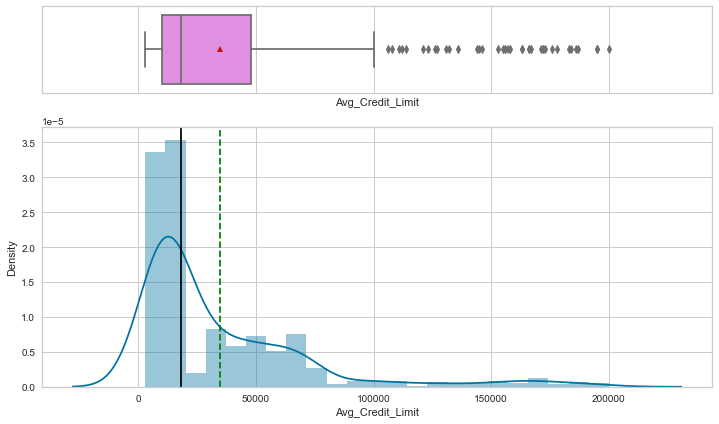

In [9]:
histogram_boxplot(df["Avg_Credit_Limit"])

- The distribution for the average credit limit is right-skewed 
- There are outliers present towards the high end which indicates that fewer customers have high credit limit.
- Few of the customers have credit limit higher than 150000, but majority of the customers credit limit is lower than 35000

### Total_Credit_Cards

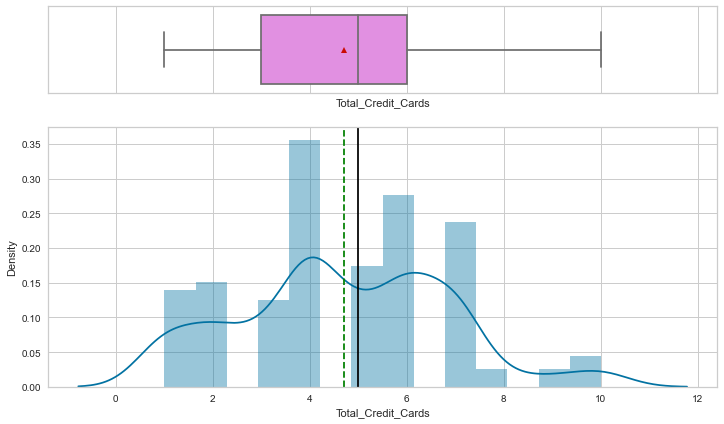

In [10]:
histogram_boxplot(df["Total_Credit_Cards"])

- The mean and median are relatively close
- Few of the customers have more than 8 credit cards
- The boxplot shows there are no outliers present

### Total_visits_bank

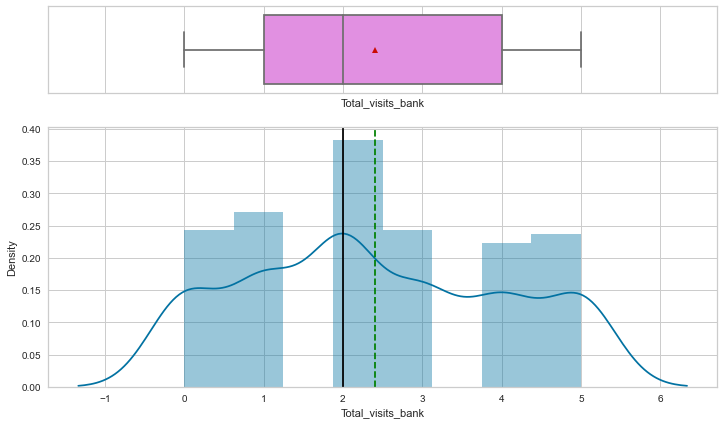

In [11]:
histogram_boxplot(df["Total_visits_bank"])

- The distibution has no outlier
- Maximum bank visit by a customer is 5

### Total_visits_online

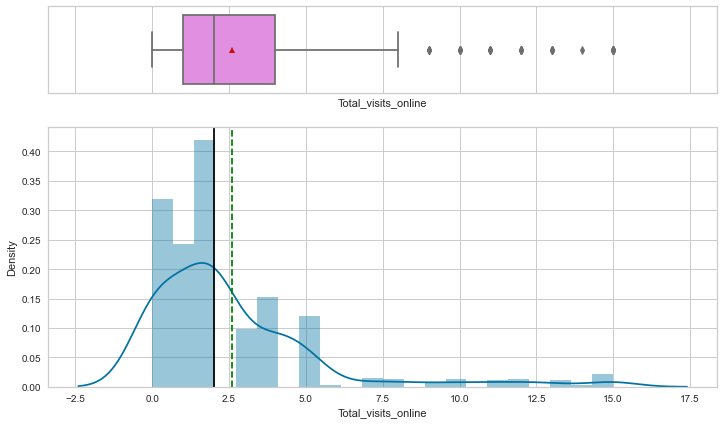

In [12]:
histogram_boxplot(df["Total_visits_online"])

- The distribution for the Total_visits_online is right-skewed 
- There are outliers present towards the right end.
- Most of the customers total online visit is less than 4

### Total_calls_made

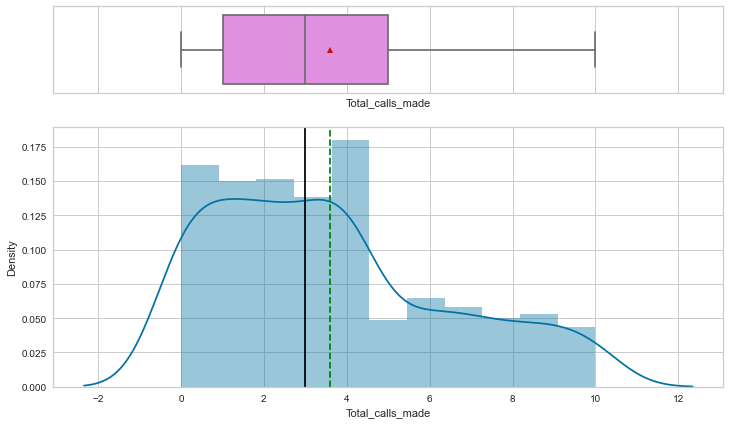

In [13]:
histogram_boxplot(df["Total_calls_made"])

- There are no otliers present in the total calls made distribution
- The maximum calls made by a customer is 10, and some of the customers didn't make any call.

In [14]:
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

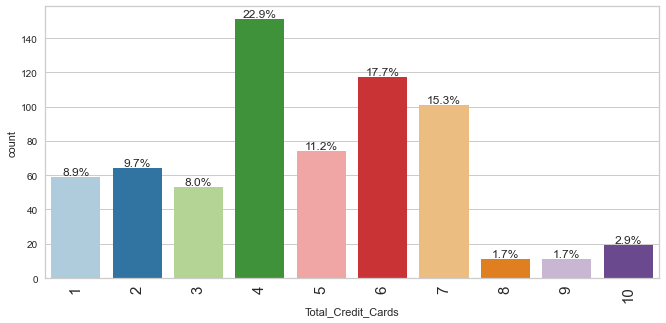

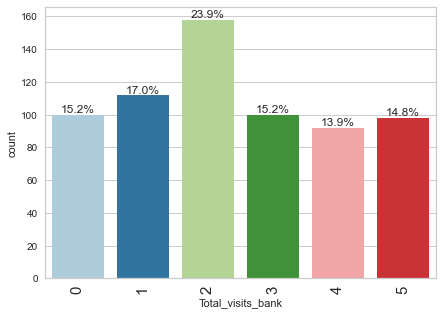

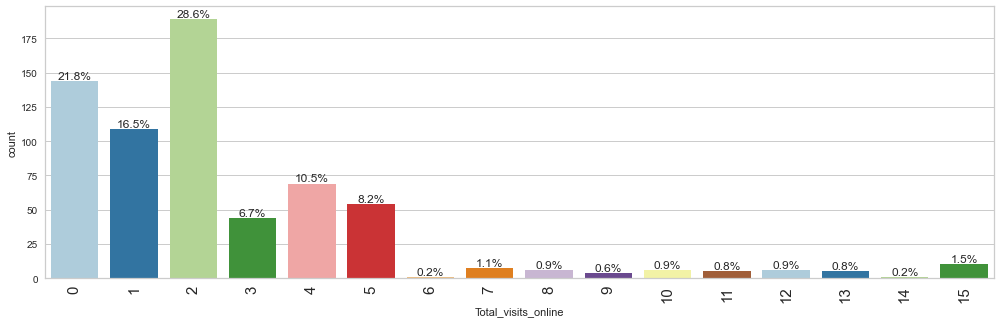

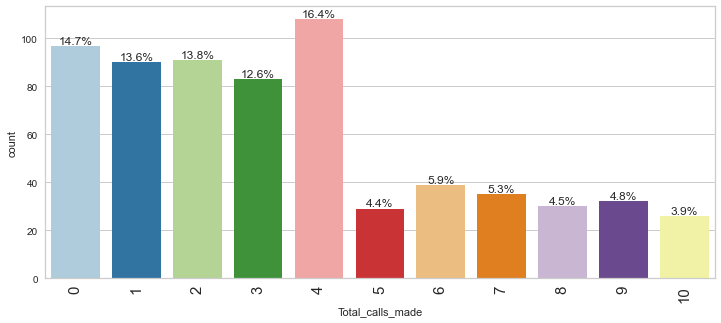

In [15]:
# selecting numerical columns
num_col = df.select_dtypes(include=np.number).columns.tolist()
num_col1 = num_col.copy()
num_col1.remove('Avg_Credit_Limit')

for item in num_col1:
    labeled_barplot(df, item, perc=True)

- More than 70% of the customers own more than 3 credit cards and less than 7% own more than 7 credit cards
- More than 10% of customers never visited the bank and 14.8% visited the bank 5 times
- 21.85 of the customers never visited or logged in to the online platform and less than 10% visited more than 6 times
- 71.7% of the customers made at least 2 calls to the bank.

### Bivariate Analsysis

**Let's check for correlations.**

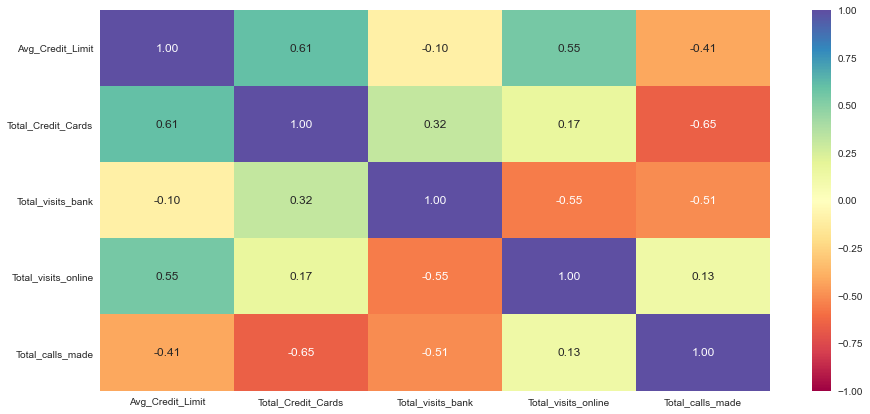

In [16]:
plt.figure(figsize=(15, 7))
sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.show()

- Total credit cards is moderately correlated to "Avg credit limit" and "Total calls made".
- Total bank visit is negatively correlated to total online visits, which indicates that customers who visit online are most likely not going to visit the bank.

**Let's scale the data set before we proceed to clustering.**

In [17]:
scaler = StandardScaler()
subset = df.copy()
subset_scaled = scaler.fit_transform(subset)

# Creating a dataframe from the scaled data
subset_scaled_df = pd.DataFrame(subset_scaled, columns=subset.columns)
subset_scaled_df.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1.740187,-1.249225,-0.860451,-0.547490,-1.251537
1,0.410293,-0.787585,-1.473731,2.520519,1.891859
2,0.410293,1.058973,-0.860451,0.134290,0.145528
3,-0.121665,0.135694,-0.860451,-0.547490,0.145528
4,1.740187,0.597334,-1.473731,3.202298,-0.203739


## K-means Clustering

Number of Clusters: 1 	Average Distortion: 2.0069222262503614
Number of Clusters: 2 	Average Distortion: 1.4571553548514269
Number of Clusters: 3 	Average Distortion: 1.1466276549150365
Number of Clusters: 4 	Average Distortion: 1.0463825294774465
Number of Clusters: 5 	Average Distortion: 0.990772333470802
Number of Clusters: 6 	Average Distortion: 0.9430843103448057
Number of Clusters: 7 	Average Distortion: 0.9094290022428964
Number of Clusters: 8 	Average Distortion: 0.8891380888508975


Text(0.5, 1.0, 'Selecting k with the Elbow Method')

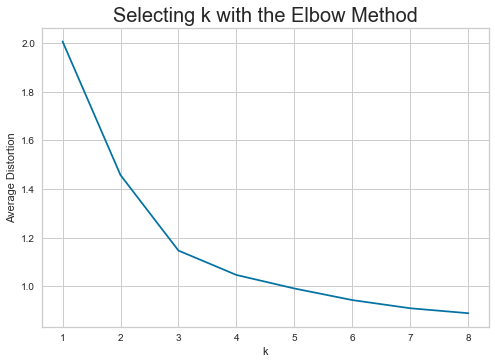

In [18]:
clusters = range(1, 9)
meanDistortions = []

for k in clusters:
    model = KMeans(n_clusters=k)
    model.fit(subset_scaled_df)
    prediction = model.predict(subset_scaled_df)
    distortion = (
        sum(
            np.min(cdist(subset_scaled_df, model.cluster_centers_, "euclidean"), axis=1)
        )
        / subset_scaled_df.shape[0]
    )

    meanDistortions.append(distortion)

    print("Number of Clusters:", k, "\tAverage Distortion:", distortion)

plt.plot(clusters, meanDistortions, "bx-")
plt.xlabel("k")
plt.ylabel("Average Distortion")
plt.title("Selecting k with the Elbow Method", fontsize=20)

**Appropriate value for k seems to be 3 or 4.**

**Let's check the silhouette scores.**

For n_clusters = 2, silhouette score is 0.41842496663230405
For n_clusters = 3, silhouette score is 0.5157182558882754
For n_clusters = 4, silhouette score is 0.355667061937737
For n_clusters = 5, silhouette score is 0.2717470361094591
For n_clusters = 6, silhouette score is 0.25601504934752495
For n_clusters = 7, silhouette score is 0.24847804076958524
For n_clusters = 8, silhouette score is 0.22612684771528263
For n_clusters = 9, silhouette score is 0.21993804286766602


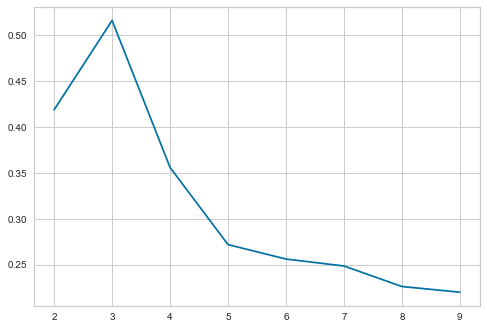

In [19]:
sil_score = []
cluster_list = list(range(2, 10))
for n_clusters in cluster_list:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict((subset_scaled_df))
    # centers = clusterer.cluster_centers_
    score = silhouette_score(subset_scaled_df, preds)
    sil_score.append(score)
    print("For n_clusters = {}, silhouette score is {}".format(n_clusters, score))

plt.plot(cluster_list, sil_score)
plt.show()

**Silhouette score for 3 is higher than that for 4. So, we will choose 3 as value of k.**

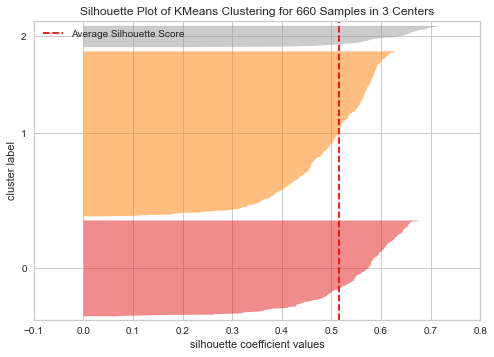

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 660 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [20]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(3, random_state=1))
visualizer.fit(subset_scaled_df)
visualizer.show()

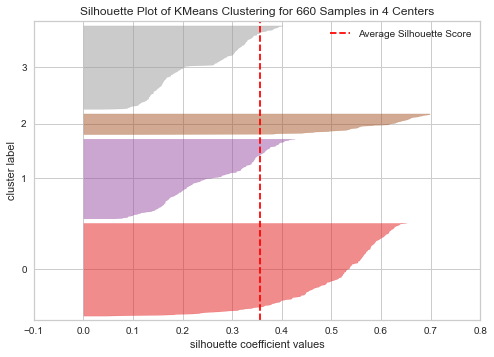

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 660 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [21]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(4, random_state=1))
visualizer.fit(subset_scaled_df)
visualizer.show()

## Hierarchical Clustering

In [22]:
# list of distance metrics
distance_metrics = ["euclidean", "chebyshev", "mahalanobis", "cityblock"]

# list of linkage methods
linkage_methods = ["single", "complete", "average", "weighted"] 

# "centroid" and "ward" wer not included because they both need the distance to be in euclidean

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(subset_scaled_df, metric=dm, method=lm)
        c, coph_dists = cophenet(Z, pdist(subset_scaled_df))
        print(
            "Cophenetic correlation for {} distance and {} linkage is {}.".format(
                dm.capitalize(), lm, c
            )
        )
        if high_cophenet_corr < c:
            high_cophenet_corr = c
            high_dm_lm[0] = dm
            high_dm_lm[1] = lm

Cophenetic correlation for Euclidean distance and single linkage is 0.7391220243806552.
Cophenetic correlation for Euclidean distance and complete linkage is 0.8599730607972423.
Cophenetic correlation for Euclidean distance and average linkage is 0.8977080867389372.
Cophenetic correlation for Euclidean distance and weighted linkage is 0.8861746814895477.
Cophenetic correlation for Chebyshev distance and single linkage is 0.7382354769296767.
Cophenetic correlation for Chebyshev distance and complete linkage is 0.8533474836336782.
Cophenetic correlation for Chebyshev distance and average linkage is 0.8974159511838106.
Cophenetic correlation for Chebyshev distance and weighted linkage is 0.8913624010768603.
Cophenetic correlation for Mahalanobis distance and single linkage is 0.7058064784553605.
Cophenetic correlation for Mahalanobis distance and complete linkage is 0.5422791209801747.
Cophenetic correlation for Mahalanobis distance and average linkage is 0.8326994115042137.
Cophenetic co

* Highest cophenetic correlation is 0.8977080867389372, which is obtained with Euclidean distance and average linkage.

**Let's explore different linkage methods with Euclidean distance only.**

In [23]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for lm in linkage_methods:
    Z = linkage(subset_scaled_df, metric="euclidean", method=lm)
    c, coph_dists = cophenet(Z, pdist(subset_scaled_df))
    print("Cophenetic correlation for {} linkage is {}.".format(lm, c))
    if high_cophenet_corr < c:
        high_cophenet_corr = c
        high_dm_lm[0] = "euclidean"
        high_dm_lm[1] = lm

Cophenetic correlation for single linkage is 0.7391220243806552.
Cophenetic correlation for complete linkage is 0.8599730607972423.
Cophenetic correlation for average linkage is 0.8977080867389372.
Cophenetic correlation for centroid linkage is 0.8939385846326323.
Cophenetic correlation for ward linkage is 0.7415156284827493.
Cophenetic correlation for weighted linkage is 0.8861746814895477.


* We see that the cophenetic correlation is still maximum with the average linkage with a score of 0.8977080867389372.

**Let's see the dendrograms for the different linkage methods.**

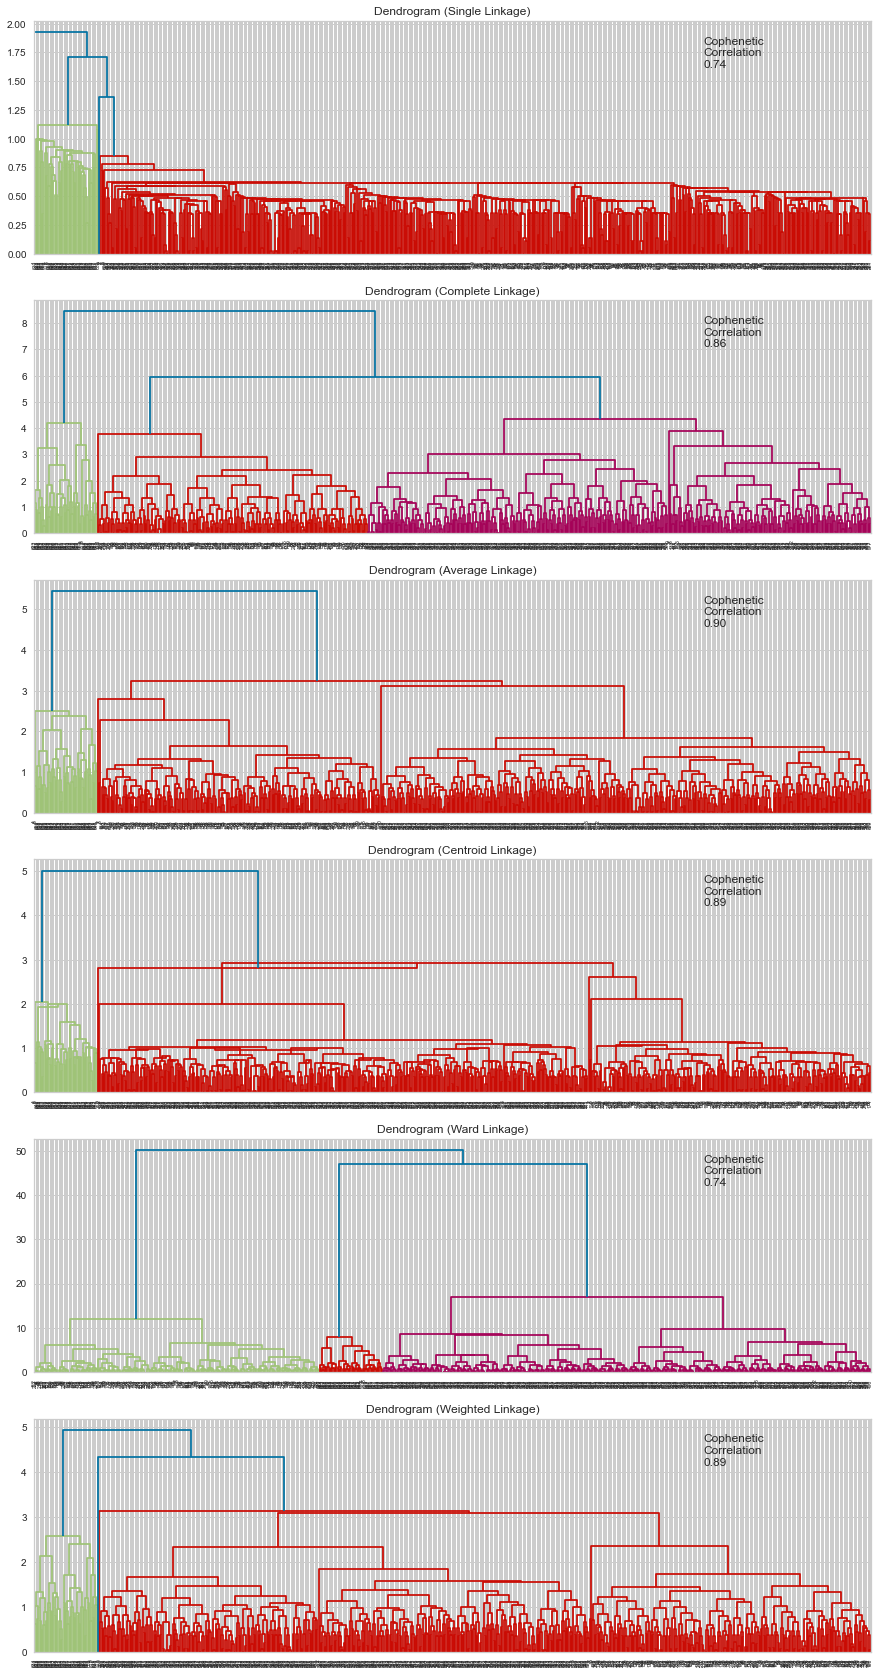

In [24]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

# lists to save results of cophenetic correlation calculation
compare_cols = ["Linkage", "Cophenetic Coefficient"]

# to create a subplot image
fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(15, 30))

# We will enumerate through the list of linkage methods above
# For each linkage method, we will plot the dendrogram and calculate the cophenetic correlation
for i, method in enumerate(linkage_methods):
    Z = linkage(subset_scaled_df, metric="euclidean", method=method)

    dendrogram(Z, ax=axs[i])
    axs[i].set_title(f"Dendrogram ({method.capitalize()} Linkage)")

    coph_corr, coph_dist = cophenet(Z, pdist(subset_scaled_df))
    axs[i].annotate(
        f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )

**Observations**

- The cophenetic correlation is highest for average linkage method.
- We will move ahead with average linkage.
- 4 appears to be the appropriate number of clusters from the dendrogram for average linkage.

In [25]:
# let's take 3 as number of K-means clusters
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(subset_scaled_df)

# adding kmeans cluster labels to the original dataframe
df1 = df.copy() #Making a copy of the original data
df1["K_means_segments"] = kmeans.labels_

In [26]:
# let's take 4 as number of hierarchical clusters
HCmodel = AgglomerativeClustering(n_clusters=4, affinity="euclidean", linkage="average")
HCmodel.fit(subset_scaled_df)

# adding Hierarchical cluster labels to the original dataframe
df2 = df.copy() #Making a copy of the original data
df2["HC_Clusters"] = HCmodel.labels_

### Comparing clusters from K-means and Hierarchical Clustering

In [27]:
# let's see the number of Avg_Credit_Limits present in each K-means cluster

for cl in df1["K_means_segments"].unique():
    print("In cluster {}, the following countries are present:".format(cl))
    print(df1[df1["K_means_segments"] == cl]["Avg_Credit_Limit"].unique())
    print()

In cluster 0, the following countries are present:
[100000  50000  30000  10000   8000  17000  19000  20000  13000  16000
  12000   5000   7000  11000   9000  18000   6000  15000  14000  73000
  49000  67000  61000  75000  48000  56000  72000  70000  51000  69000
  40000  44000  31000  37000  65000  46000  74000  58000  39000  52000
  33000  47000  71000  41000  59000  64000  45000  54000  66000  27000
  43000  36000  25000  57000  26000  38000  35000  34000  28000  63000
  29000  68000  42000  62000  32000  60000  55000]

In cluster 1, the following countries are present:
[50000 20000 15000  5000  3000 10000 13000 11000  9000  6000  8000 19000
 16000 18000 17000 14000 12000  7000]

In cluster 2, the following countries are present:
[100000 157000  94000 163000 131000  96000 136000 121000 158000 108000
 166000 176000 178000  91000 156000 146000  84000 155000 200000 195000
 187000 106000 114000 126000 173000 153000 184000 123000 144000  97000
  98000 127000 171000 186000 183000 111000 1

In [28]:
# let's see the number of Avg_Credit_Limits present in each Hierarchical cluster

for cl in df2["HC_Clusters"].unique():
    print("In cluster {}, the following countries are present:".format(cl))
    print(df2[df2["HC_Clusters"] == cl]["Avg_Credit_Limit"].unique())
    print()

In cluster 3, the following countries are present:
[100000]

In cluster 0, the following countries are present:
[50000 20000 15000  5000  3000 10000 13000 11000  9000  6000  8000 19000
 16000 18000 17000 14000 12000  7000]

In cluster 2, the following countries are present:
[50000 30000 10000  8000 17000 19000 20000 13000 16000 12000  5000  7000
 11000  9000 18000  6000 15000 14000 73000 49000 67000 61000 75000 48000
 56000 72000 70000 51000 69000 40000 44000 31000 37000 65000 46000 74000
 58000 39000 52000 33000 47000 71000 41000 59000 64000 45000 54000 66000
 27000 43000 36000 25000 57000 26000 38000 35000 34000 28000 63000 29000
 68000 42000 62000 32000 60000 55000]

In cluster 1, the following countries are present:
[100000 157000  94000 163000 131000  96000 136000 121000 158000 108000
 166000 176000 178000  91000 156000 146000  84000 155000 200000 195000
 187000 106000 114000 126000 173000 153000 184000 123000 144000  97000
  98000 127000 171000 186000 183000 111000 112000 132000 

- We see that there are 2 similar clusters in both techniques and the 4th cluster in the hierarchical technique only has 1 avg credit limit present, which is the ony difference from both techniques.

## Cluster Profiling

### K-means Cluster Profiling

In [29]:
cluster_profile_kmeans = df1.groupby("K_means_segments").mean()

cluster_profile_kmeans["count_in_each_segment"] = (
    df1.groupby("K_means_segments")["Avg_Credit_Limit"].count().values
)

In [30]:
# let's display cluster profiles
cluster_profile_kmeans.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segment
K_means_segments,,,,,,
0,33782.383420,5.515544,3.489637,0.981865,2.000000,386
1,12174.107143,2.410714,0.933036,3.553571,6.870536,224
2,141040.000000,8.740000,0.600000,10.900000,1.080000,50


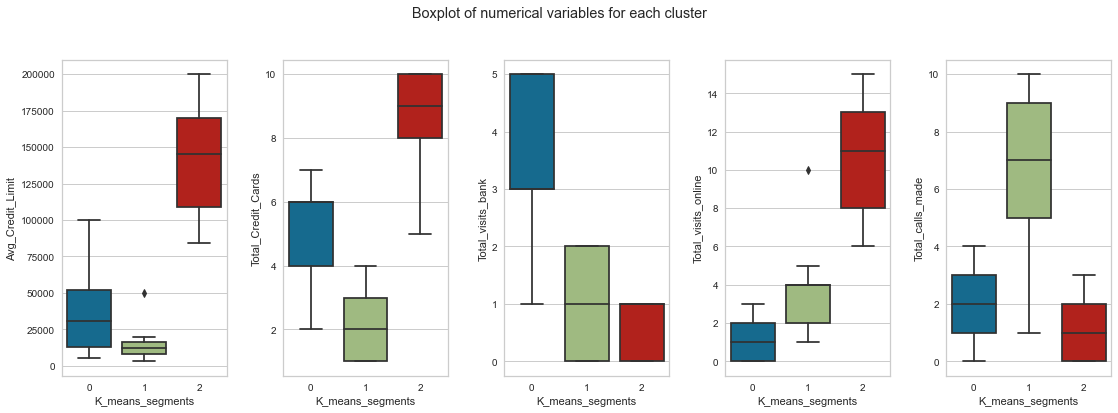

In [31]:
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Boxplot of numerical variables for each cluster")
counter = 0
for ii in range(5):
    sns.boxplot(ax=axes[ii], y=df1[num_col[counter]], x=df1["K_means_segments"])
    counter = counter + 1

fig.tight_layout(pad=2.0)

### Hierarchichal Cluster Profiling

In [32]:
cluster_profile_hc = df2.groupby("HC_Clusters").mean()

cluster_profile_hc["count_in_each_segments"] = (
    df2.groupby("HC_Clusters")["Avg_Credit_Limit"].count().values
)

In [33]:
# let's display cluster profiles
cluster_profile_hc.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segments
HC_Clusters,,,,,,
0,12197.309417,2.403587,0.928251,3.560538,6.883408,223
1,141040.000000,8.740000,0.600000,10.900000,1.080000,50
2,33541.450777,5.520725,3.492228,0.984456,2.010363,386
3,100000.000000,2.000000,1.000000,1.000000,0.000000,1


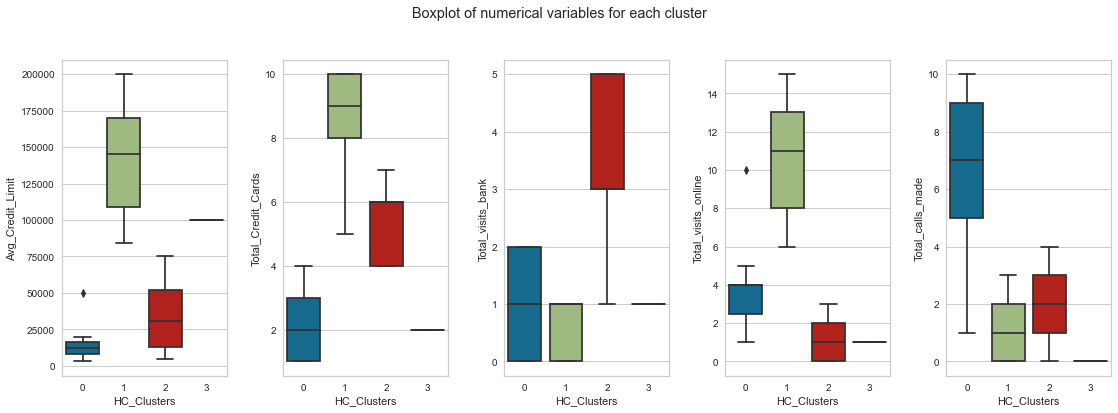

In [34]:
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Boxplot of numerical variables for each cluster")
counter = 0
for ii in range(5):
    sns.boxplot(ax=axes[ii], y=df2[num_col[counter]], x=df2["HC_Clusters"])
    counter = counter + 1

fig.tight_layout(pad=2.0)

**Some clusters from both techniques are similar**

### K-means Cluster Profiling Insights

- **Cluster 0**:
    - Average credit limit in this cluster ranges between 5000 to 10000.
    - Total credit cards possessed by customers in this cluster is averaged at approximately 4.
    - Majority of the customers visit the bank more than 3 times and make an average of 2 calls to the bank.
    - Some customers in this cluster don't utilize the online platform while some visit the online platform twice or less.


- **Cluster 1**:
    - Majority's average credit limit ranges between 3000 to 20000. There is an outlier of 50000.
    - Customers in this cluster possess between 1 to 4 credit cards.
    - Customers in this cluster prefer calling the bank, have a maximum bank visit of 2 and total online visit ranges from 1 to 5.


- **Cluster 2**:
    - Average credit limit in this cluster ranges between 84000 to 200000.
    - Customers in this cluster own as much as 10 credit cards and are less likely going to visit the bank.
    - Customers make less calls to the bank and utilizes the online platform more that the other two clusters.
    
### Hierarchichal Cluster Profiling Insights

- **Cluster 0**
   - This cluster is similar to cluster 1 in the k-means cluster
   
- **Cluster 1**
   - This cluster is similar to cluster 2 in the k-means cluster
   
- **Cluster 2**
   - Average credit limit in this cluster ranges between 5000 to 75000.
   - Majority of the customers possess between 4 to 6 credit cards and very few possess above 6
   - Few of the customers visit the bank less than 3 times and majority visit the bank between 3 to 5 times
   - Most customers in this cluster visit the online platform less than 2 times and make an average of 2 calls to the bank
- **Cluster 3**
   - This cluster have only 1 customer with an average credit limit of 100000 and possess 2 credit cards 
   - Customer visited the bank/online once and didn't make any call to the bank.

## Business Recommendations

- K-means and Hierarchical clustering algorithms were utilized  to identify different segments in the existing bank customers, based on their spending patterns and past interaction with the bank. 
- K-means clustering gave a better customers segmentation which consists of 3 clusters. 
- **Cluster 2** consists of premium customers with very high average credit limit, possess the most credit cards and they utilize the online platform more, so personalized marketing campaigns can be done to target this customers’ by running an ad when they login to their account and improvement feedback ratings can be optionally requested from this customers’ when they log off their account to help the bank know how to better service them.
- **Cluster 1** consists of customers with relatively low average credit limits, possess less than 5 credit cards and make the highest calls to the bank. The bank should work on reducing the wait time for calls and send a feedback survey to the customers’ phone once they get off the call to get feedback on how well they receive the service rendered also, an option for what they need improvement should be included.
- **Cluster 0** consists of customers whom their average credit limit ranges between 5000 to 100000, possess either 4 or less than 4 credit cards. Most customers in this cluster visit the bank more, the bank can implement training their employees to improve their customer relationship to better service customers in this cluster, also pamphlet containing information about new products should be readily available and handed to the customers once they are about leaving the bank.